#### Import libraries

In [1]:
import os
import matplotlib.pyplot as plt
import json

import rasterio
from rasterio.windows import Window
from rasterio.plot import show
from rasterio.features import rasterize

import geopandas as gpd
from shapely.geometry import box

import numpy as np

from acquisition_alignment.dl_functions import download_osm, get_building_bbox, download_sentinel2_images_openeo
from acquisition_alignment.connect_openeo import connect_to_openeo
from acquisition_alignment.plt_functions import plot_city_buildings, rgb_image, single_band_image, overlay_image, irb_image
from data_preparation.preparation import create_building_mask, create_patches
from modeling_tuning.models import BaselineCNN, UNet

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
import gc
import torch.nn.functional as F

from concurrent.futures import ThreadPoolExecutor

torch.cuda.empty_cache()
gc.collect()

0

## 1.1 Data Acquisition and Alignment

### Define 10 "big" cities + Test City

In [3]:
# List of 10 'big' cities + Test city
city_names = ["Berlin", "Koeln", "Frankfurt", "Stuttgart", "Dortmund", "Duesseldorf", "Bremen", "Leipzig", "Dresden", "Muenchen", "Hamburg"]

### Loop through 10 'big' cities and download OSM files

In [4]:
# Download path
pyrosm_path = f"acquisition_alignment/pyrosm_cities/"
os.makedirs(pyrosm_path, exist_ok=True)

In [42]:
# 1 min
# Loop through each city and download OSM
for city in city_names:
    #Download and process OSM data
    download_osm(city, pyrosm_path)
    print(f"Download of {city} done.\n")

Berlin data was downloaded to: c:\Users\PC\Desktop\TU\AMLS\acquisition_alignment\pyrosm_cities\Berlin.osm.pbf
Download of Berlin done.

Koeln data was downloaded to: c:\Users\PC\Desktop\TU\AMLS\acquisition_alignment\pyrosm_cities\Koeln.osm.pbf
Download of Koeln done.

Frankfurt data was downloaded to: c:\Users\PC\Desktop\TU\AMLS\acquisition_alignment\pyrosm_cities\Frankfurt.osm.pbf
Download of Frankfurt done.

Stuttgart data was downloaded to: c:\Users\PC\Desktop\TU\AMLS\acquisition_alignment\pyrosm_cities\Stuttgart.osm.pbf
Download of Stuttgart done.

Dortmund data was downloaded to: c:\Users\PC\Desktop\TU\AMLS\acquisition_alignment\pyrosm_cities\Dortmund.osm.pbf
Download of Dortmund done.

Duesseldorf data was downloaded to: c:\Users\PC\Desktop\TU\AMLS\acquisition_alignment\pyrosm_cities\Duesseldorf.osm.pbf
Download of Duesseldorf done.

Bremen data was downloaded to: c:\Users\PC\Desktop\TU\AMLS\acquisition_alignment\pyrosm_cities\Bremen.osm.pbf
Download of Bremen done.

Leipzig data

### Load buildings and bboxes of cities

In [5]:
# ~11 min
cities_data = {}
for city in city_names[3:4]:
    buildings_gdf, bbox = get_building_bbox(pyrosm_path, city)
    print(bbox)
    cities_data[city] = [buildings_gdf, bbox]
    print(f"Get buildings and boundaries of {city} done.\n")

c:\Users\PC\Desktop\TU\AMLS\acquisition_alignment\pyrosm_cities\Stuttgart.osm.pbf
OSM data get_buildings done.
OSM for Stuttgart converted into GeoDataFrame, with crs=EPSG:4326 done.
OSM data get_boundaries done.
[48.93000030517578, 48.46000671386719, 8.790005683898926, 9.499994277954102]
Get buildings and boundaries of Stuttgart done.



### Download Satellite images (.tif files) and plotting

#### Connect to openeo.dataspace.copernicus

In [ ]:
# Connect to OpenEO
connection = connect_to_openeo()

#### Download Sentinel 2 L2a Data

In [ ]:
# 30 - 40 min for all the cities.
dates_interval = ["2021-06-01T12:00:00Z", "2021-07-30T12:01:00Z"]
cloud_cover_percentage = 6

for city in city_names:
    openeo_path = f"acquisition_alignment/openeo_cities/{city}/"
    # Ensure the directory exists
    os.makedirs(openeo_path, exist_ok=True)
    
    # Get bbox of a city from OSM data
    _, bbox = cities_data[city]
    
    # Download Sentinel-2 L2a images with 4 bands and cloud cover param.
    download_sentinel2_images_openeo(connection, bbox, dates_interval, cloud_cover_percentage, openeo_path)

### Buildings Plot and Images

In [7]:
band_index = 1  # For single band. Band index to read (1 for B04, 2 for B03, 3 for B02, 4 for B08) (cmap=gray anyway). Start index is 1 because rasterio.

# Loop through each city in the dictionary and save image of the buildings of the city
for city, data in cities_data.items():
    # Path to the Sentinel-2 L2a image of a city
    sentinel2_path = f"acquisition_alignment/openeo_cities/{city}/{city}.tif"

    buildings_gdf, _ = data

    # Make directory for the images (for city). Ensure the directory exists
    images_save_dir = f"acquisition_alignment/images/{city}/"
    os.makedirs(images_save_dir, exist_ok=True)

    print("1 (a) Buildings from OpenStreetMaps.")
    plot_city_buildings(city, buildings_gdf, images_save_dir)

    print("1 (b) RGB Bands from Sentinel 2.")
    rgb_image(sentinel2_path, images_save_dir)

    print("2 (a) Single Band.")
    single_band_image(sentinel2_path, images_save_dir, band_index)

    print("2 (b) Overlap Buildings from OSM onto Sentinel-2 image.")
    overlay_image(buildings_gdf, sentinel2_path, images_save_dir, band_index)

    print("2 (c) IRB")
    irb_image(sentinel2_path, images_save_dir)
    print(f"All savings for {city} done")
    break # One should be enough to be sure projection is correct

1 (a) Buildings from OpenStreetMaps.
1 (b) RGB Bands from Sentinel 2.
2 (a) Single Band.
2 (b) Overlap Buildings from OSM onto Sentinel-2 image.
2 (c) IRB
All savings for Stuttgart done


## 1.2 Dataset Preparation

### Save huge mask with buildings for each huge city in a .tif file

In [ ]:
# ~12 min
# Load the received Sentinel-2 image
for city, data in cities_data.items():
    image_path = f"acquisition_alignment/openeo_cities/{city}/{city}.tif"  # Iterate over each of the 10 Sentinel files
    buildings_gdf, _ = data

    with rasterio.open(image_path) as src:
        satellite_crs = src.crs
        transform = src.transform
        width = src.width
        height = src.height

    buildings_gdf = buildings_gdf.to_crs(src.crs) # OSM to Sentinel CRS

    # Create the building mask
    buildings_mask = create_building_mask(buildings_gdf, transform, width, height) # 0/1 = black white

    # Save the building mask as a new .tif file
    mask_path = f'acquisition_alignment/openeo_cities/{city}/{city}_buildings_mask.tif'
    with rasterio.open(
        mask_path,
        'w',
        driver='GTiff',
        height=buildings_mask.shape[0],
        width=buildings_mask.shape[1],
        count=1,
        dtype=buildings_mask.dtype,  # use the same data type as the mask
        crs=satellite_crs,
        transform=transform,
    ) as dst:
        dst.write(buildings_mask, 1)

### Load created .tif masks and look at them

Berlin
Unique values in mask: [0 1]


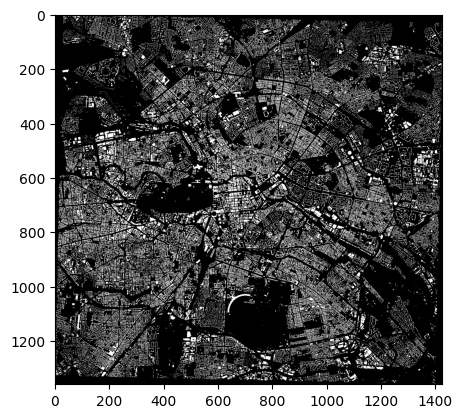

Koeln
Unique values in mask: [0 1]


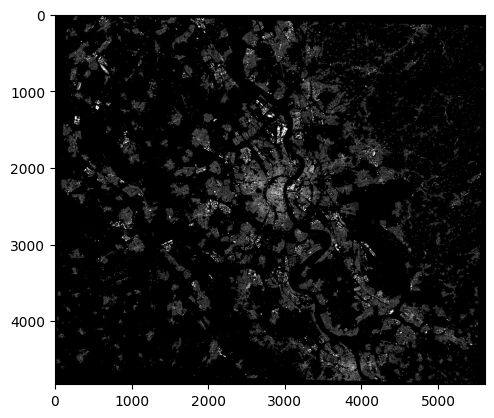

In [ ]:
for city in city_names[0:2]:
    mask_path = f'acquisition_alignment/openeo_cities/{city}/{city}_buildings_mask.tif'
    # Load the building mask
    print(f"{city}")
    with rasterio.open(mask_path) as src:
        buildings_mask = src.read(1)  # Mask is in the first band

    # Check the unique values in the mask
    unique_values = np.unique(buildings_mask)
    print("Unique values in mask:", unique_values)

    # Display the mask with a grayscale colormap
    show(buildings_mask, cmap='gray')

### Analyse buildings distribution in Test label and filter patches according to this distribution +-

In [4]:
test_mask_path = "acquisition_alignment/openeo_cities/Berlin/Berlin_buildings_mask.tif"
# Load the test mask image using rasterio
with rasterio.open(test_mask_path) as src:
    test_mask = src.read(1)  # Read the first band
print(test_mask.shape)
# Calculate the building pixel ratio for the test image
total_pixels_test = test_mask.size
building_pixels_test = np.sum(test_mask == 1)  # Count pixels with value 1
building_pixel_ratio_test = building_pixels_test / total_pixels_test

print(f'Building Pixel Ratio for Test Label: {building_pixel_ratio_test}')

# Define tolerance range: x%
tolerance = 0.85
lower_bound = building_pixel_ratio_test * (1 - tolerance)
upper_bound = building_pixel_ratio_test * (1 + tolerance)

print(f"Lower tolerance for patches: {lower_bound},\nUpper tolerance for patches: {upper_bound}")

(1360, 1425)
Building Pixel Ratio for Test Label: 0.2018390092879257
Lower tolerance for patches: 0.03027585139318886,
Upper tolerance for patches: 0.37340216718266256


### Create Trainset. <br>Berlin and 2 last cities are excluded. <br>Make 128x128 Patches for Trainset. Save them and load.. 

#### Create train patches

In [10]:
# Parameters
patch_size = 128  # Define the patch size (32, 64, or 128)

# Initialize lists to store all image and mask patches
train_img_patches = []
train_mask_patches = []

# Iterate over each city to create patches
for city in city_names[1:-2]: # 0 is Berlin, do not include into patches. Last 2 cities (Hamburg and Muenchen are used for validation)
    image_path = f"acquisition_alignment/openeo_cities/{city}/{city}.tif"  # Path to the large image
    mask_path = f"acquisition_alignment/openeo_cities/{city}/{city}_buildings_mask.tif"  # Path to the binary mask image
    
    # Create patches for current city
    img_patches, mask_patches = create_patches(image_path, mask_path, patch_size, lower_bound, upper_bound)
    
    # Append current city patches to the lists
    train_img_patches.append(img_patches)
    train_mask_patches.append(mask_patches)

# Concatenate all city patches along the first dimension (N)
train_img_patches = np.concatenate(train_img_patches, axis=0)
train_mask_patches = np.concatenate(train_mask_patches, axis=0)

# Print shapes to verify
print(f"Image patches shape: {train_img_patches.shape}")  # Expected: [N, C, H, W]
print(f"Mask patches shape: {train_mask_patches.shape}")  # Expected: [N, H, W]

Image patches shape: (3924, 4, 128, 128)
Mask patches shape: (3924, 128, 128)


#### Save train Patches

In [11]:
# Save image and mask as .npy files
np.save('data_preparation/train_img_patches.npy', train_img_patches)
np.save('data_preparation/train_mask_patches.npy', train_mask_patches)
print("Saved image and mask as .npy files.")

Saved image and mask as .npy files.


### Create Validation set. <br>Crop 2 last cities (Hamburg and Muenchen) for Validation.

#### Crop Hamburg

In [ ]:
image_path = f'acquisition_alignment/openeo_cities/Hamburg/Hamburg.tif'

# Load the .tif file
with rasterio.open(image_path) as src:
    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height

# Upper left point (column and row from QGIS) and the desired width and height in pixels
upper_left_col = 3810  # column (x) from QGIS
upper_left_row = 2365  # row (y) from QGIS
crop_height = 1360    # desired height in pixels
crop_width = 1425     # desired width in pixels

# Define the window to crop
window = Window(upper_left_col, upper_left_row, crop_width, crop_height)

# Crop the image
with rasterio.open(image_path) as src:
    cropped_image = src.read(window=window)
    cropped_transform = src.window_transform(window)

# Save the cropped image
output_path = 'acquisition_alignment/openeo_cities/Hamburg/Hamburg_cropped.tif'
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=crop_height,
    width=crop_width,
    count=4,  # Number of bands
    dtype=cropped_image.dtype,
    crs=crs,
    transform=cropped_transform,
) as dst:
    for i in range(1, 5):
        dst.write(cropped_image[i-1], i) # raster bands are 1-indexed in rasterio

print(f"Cropped image saved to {output_path}")


Cropped image saved to acquisition_alignment/openeo_cities/Hamburg/Hamburg_cropped.tif


#### Create Mask for Cropped Hamburg

In [ ]:
# ~ 40 sec
# Paths to the files
cropped_image_path = 'acquisition_alignment/openeo_cities/Hamburg/Hamburg_cropped.tif'
buildings_gdf, _ = cities_data["Hamburg"]

# Open the cropped image and get its properties
with rasterio.open(cropped_image_path) as src:
    cropped_crs = src.crs
    cropped_transform = src.transform
    cropped_bounds = src.bounds
    cropped_width = src.width
    cropped_height = src.height

# Fix invalid geometries in the buildings GeoDataFrame
buildings_gdf['geometry'] = buildings_gdf['geometry'].buffer(0)

# Reproject the buildings GeoDataFrame to match the CRS of the cropped image
buildings_gdf = buildings_gdf.to_crs(cropped_crs)

# Clip the buildings GeoDataFrame to the bounds of the cropped image
# Create a bounding box geometry from the bounds of the cropped image
cropped_bbox = box(*cropped_bounds)
cropped_bbox_gdf = gpd.GeoDataFrame({'geometry': [cropped_bbox]}, crs=cropped_crs)

# Perform the intersection to get buildings within the cropped bounds
buildings_gdf = gpd.overlay(buildings_gdf, cropped_bbox_gdf, how='intersection')

# Rasterize the buildings GeoDataFrame
out_shape = (cropped_height, cropped_width)
transform = cropped_transform

# Use the geometry and an attribute to rasterize
buildings_mask = rasterize(
    [(geom, 1) for geom in buildings_gdf.geometry],
    out_shape=out_shape,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype='uint8'
)

# Save the mask as a .tif file
mask_output_path = 'acquisition_alignment/openeo_cities/Hamburg/Hamburg_buildings_mask_cropped.tif'

# Save the rasterized mask to a new .tif file
with rasterio.open(
    mask_output_path,
    'w',
    driver='GTiff',
    height=cropped_height,
    width=cropped_width,
    count=1,
    dtype='uint8',
    crs=cropped_crs,
    transform=transform
) as dst:
    dst.write(buildings_mask, 1)

print(f"Projected buildings mask saved to {mask_output_path}")


Projected buildings mask saved to acquisition_alignment/openeo_cities/Hamburg/Hamburg_buildings_mask_cropped.tif


##### Show mask of Hamburg

In [ ]:
# Path to the building mask file
mask_file_path = 'acquisition_alignment/openeo_cities/Hamburg/Hamburg_buildings_mask_cropped.tif'

# Load the mask
with rasterio.open(mask_file_path) as mask_src:
    mask = mask_src.read(1)  # Read the first band

# Display the mask
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.title('Building Mask Muenchen')
plt.axis('off')
plt.show()

#### Crop Muenchen

In [ ]:
image_path = f'acquisition_alignment/openeo_cities/Muenchen/Muenchen.tif'

# Load the .tif file
with rasterio.open(image_path) as src:
    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height

# Upper left point (column and row from QGIS) and the desired width and height in pixels
upper_left_col = 3015  # example column (x) from QGIS
upper_left_row = 2660  # example row (y) from QGIS
crop_height = 1360    # desired height in pixels
crop_width = 1425     # desired width in pixels

# Define the window to crop
window = Window(upper_left_col, upper_left_row, crop_width, crop_height)

# Crop the image
with rasterio.open(image_path) as src:
    cropped_image = src.read(window=window)
    cropped_transform = src.window_transform(window)

# Save the cropped image
output_path = 'acquisition_alignment/openeo_cities/Muenchen/Muenchen_cropped.tif'
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=crop_height,
    width=crop_width,
    count=4,  # Number of bands
    dtype=cropped_image.dtype,
    crs=crs,
    transform=cropped_transform,
) as dst:
    for i in range(1, 5):
        dst.write(cropped_image[i-1], i) # raster bands are 1-indexed in rasterio

print(f"Cropped image saved to {output_path}")

Cropped image saved to acquisition_alignment/openeo_cities/Muenchen/Muenchen_cropped.tif


#### Create Mask for cropped Muenchen

In [ ]:
# Paths to the files
cropped_image_path = 'acquisition_alignment/openeo_cities/Muenchen/Muenchen_cropped.tif'
buildings_gdf, _ = cities_data["Muenchen"]

# Open the cropped image and get its properties
with rasterio.open(cropped_image_path) as src:
    cropped_crs = src.crs
    cropped_transform = src.transform
    cropped_bounds = src.bounds
    cropped_width = src.width
    cropped_height = src.height

# Fix invalid geometries in the buildings GeoDataFrame
buildings_gdf['geometry'] = buildings_gdf['geometry'].buffer(0)

# Reproject the buildings GeoDataFrame to match the CRS of the cropped image
buildings_gdf = buildings_gdf.to_crs(cropped_crs)

# Clip the buildings GeoDataFrame to the bounds of the cropped image
# Create a bounding box geometry from the bounds of the cropped image
cropped_bbox = box(*cropped_bounds)
cropped_bbox_gdf = gpd.GeoDataFrame({'geometry': [cropped_bbox]}, crs=cropped_crs)

# Perform the intersection to get buildings within the cropped bounds
buildings_gdf = gpd.overlay(buildings_gdf, cropped_bbox_gdf, how='intersection')

# Rasterize the buildings GeoDataFrame
out_shape = (cropped_height, cropped_width)
transform = cropped_transform

# Use the geometry and an attribute to rasterize
buildings_mask = rasterize(
    [(geom, 1) for geom in buildings_gdf.geometry],
    out_shape=out_shape,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype='uint8'
)

# Save the mask as a .tif file
mask_output_path = 'acquisition_alignment/openeo_cities/Muenchen/Muenchen_buildings_mask_cropped.tif'

# Save the rasterized mask to a new .tif file
with rasterio.open(
    mask_output_path,
    'w',
    driver='GTiff',
    height=cropped_height,
    width=cropped_width,
    count=1,
    dtype='uint8',
    crs=cropped_crs,
    transform=transform
) as dst:
    dst.write(buildings_mask, 1)

print(f"Projected buildings mask saved to {mask_output_path}")


Projected buildings mask saved to acquisition_alignment/openeo_cities/Muenchen/Muenchen_buildings_mask_cropped.tif


##### Show Mask of cropped Muenchen

In [ ]:
# Path to the building mask file
mask_file_path = 'acquisition_alignment/openeo_cities/Muenchen/Muenchen_buildings_mask_cropped.tif'

# Load the mask
with rasterio.open(mask_file_path) as mask_src:
    mask = mask_src.read(1)  # Read the first band

# Display the mask
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.title('Building Mask Muenchen')
plt.axis('off')
plt.show()

#### Create Validation tensors from Hamburg and Muenchen. Save and load..

In [ ]:
# Function to load whole image and mask and return
def load_image_and_mask(image_path, mask_path):
    with rasterio.open(image_path) as src:
        img = src.read()

    with rasterio.open(mask_path) as src_mask:
        mask_img = src_mask.read(1)

    return img, mask_img

# Define paths to validation images and masks
validation_data = [
    {"image": "acquisition_alignment/openeo_cities/Hamburg/Hamburg_cropped.tif", "mask": "acquisition_alignment/openeo_cities/Hamburg/Hamburg_buildings_mask_cropped.tif"},
    {"image": "acquisition_alignment/openeo_cities/Muenchen/Muenchen_cropped.tif", "mask": "acquisition_alignment/openeo_cities/Muenchen/Muenchen_buildings_mask_cropped.tif"}
]

# Initialize lists to store image and mask tensors
val_images_list = []
val_masks_list = []

# Load validation tensors into memory and store in lists
for data in validation_data:
    img_path = data["image"]
    mask_path = data["mask"]
    
    img, mask = load_image_and_mask(img_path, mask_path)
    val_images_list.append(img)
    val_masks_list.append(mask)

# Convert lists to numpy arrays
val_images = np.array(val_images_list)
val_masks = np.array(val_masks_list)

#### Check Dimensions of validation Patches

In [ ]:
print(f"Image patches shape: {val_images.shape}")  # Expected: [N, C, H, W]
print(f"Mask patches shape: {val_masks.shape}")  # Expected: [N, H, W]

#### Save validation tensors

In [6]:
# Save image and mask tensors as .npy files
np.save('data_preparation/val_images.npy', val_images)
np.save('data_preparation/val_masks.npy', val_masks)

print("Saved image and mask tensors as .npy files.")

NameError: name 'val_images' is not defined

### Create Testset.

In [5]:
# Define paths to test image and mask
image_path = "acquisition_alignment/openeo_cities/Berlin/Berlin.tif"
mask_path = "acquisition_alignment/openeo_cities/Berlin/Berlin_buildings_mask.tif"

# Read the image using rasterio
with rasterio.open(image_path) as src:
    img = src.read()

# Read the mask using rasterio
with rasterio.open(mask_path) as src_mask:
    mask = src_mask.read(1)

# Save the image and mask as npy files
np.save('data_preparation/test_image.npy', img)
np.save('data_preparation/test_mask.npy', mask)

print(f"Image patches shape: {img.shape}")  # Expected: [N, C, H, W]
print(f"Mask patches shape: {mask.shape}")  # Expected: [N, H, W]

print("Image and mask have been saved as npy files.")

Image patches shape: (4, 1360, 1425)
Mask patches shape: (1360, 1425)
Image and mask have been saved as npy files.


## 1.3 Modeling and Tuning

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
gc.collect()

cuda


0

### Load Train Patches

In [192]:
# Load the train .npy train files
train_img_patches = np.load('data_preparation/train_img_patches.npy')
train_mask_patches = np.load('data_preparation/train_mask_patches.npy')
print("Loaded train image and mask from .npy files.")

# Print shapes to verify
print(f"Image patches shape: {train_img_patches.shape}")  # Expected: [N, C, H, W]
print(f"Mask patches shape: {train_mask_patches.shape}")  # Expected: [N, H, W]

# Convert numpy arrays to PyTorch tensors and move to GPU if available
train_images = torch.tensor(train_img_patches, dtype=torch.float32).to(device)
train_masks = torch.tensor(train_mask_patches, dtype=torch.float32).to(device)
print("Converted to pytorch tensors")

Loaded train image and mask from .npy files.
Image patches shape: (3924, 4, 128, 128)
Mask patches shape: (3924, 128, 128)
Converted to pytorch tensors


### Load Validation Patches

In [193]:
# Load .npy validation files
val_images = np.load('data_preparation/val_images.npy')
val_masks = np.load('data_preparation/val_masks.npy')
print("Loaded validation image and mask arrays from .npy files.")

# Print shapes to verify
print(f"Image patches shape: {val_images.shape}")  # Expected: [N, C, H, W]
print(f"Mask patches shape: {val_masks.shape}")  # Expected: [N, H, W]

# Convert numpy arrays to PyTorch tensors and move to GPU if available
val_images = torch.tensor(val_images, dtype=torch.float32).to(device)
val_masks = torch.tensor(val_masks, dtype=torch.float32).to(device)
print("Converted to pytorch tensors")

Loaded validation image and mask arrays from .npy files.
Image patches shape: (2, 4, 1360, 1425)
Mask patches shape: (2, 1360, 1425)
Converted to pytorch tensors


### Load Testset

In [209]:
# Load .npy test files
test_image = np.load('data_preparation/test_image.npy')
test_mask = np.load('data_preparation/test_mask.npy')
print("Loaded test image and mask arrays from .npy files.")

# Print shapes to verify
print(f"Image patches shape: {test_image.shape}")  # Expected: [C, H, W]
print(f"Mask patches shape: {test_mask.shape}")  # Expected: [H, W]

# Convert numpy arrays to PyTorch tensors and move to GPU if available
test_image = torch.tensor(test_image, dtype=torch.float32).to(device)
test_mask = torch.tensor(test_mask, dtype=torch.float32).to(device)
print("Converted to pytorch tensors")

Loaded test image and mask arrays from .npy files.
Image patches shape: (4, 1360, 1425)
Mask patches shape: (1360, 1425)
Converted to pytorch tensors


### Define Hyperparameters

In [296]:
train_images = train_images[:,:3,:,:]
train_images.shape, train_masks.shape

val_images = val_images[:,:3,:,:]
val_images.shape, val_masks.shape

test_image = test_image[:3,:,:]

BATCH_SIZE = 8
params = [
    {"model_id": 6, "in_channels": 3, "optimizer": torch.optim.Adam, "learning_rate": 0.0008, "weight_decay": 5e-4, "patience": 1, "delta": 0.05, "num_epochs": 4}
    # Add more parameter sets as needed
]
model_id = params[0]["model_id"]

### Define DataLoaders

In [286]:
# Create TensorDataset and DataLoader for training and validation
train_dataset = TensorDataset(train_images, train_masks)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(val_images, val_masks)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Use batch_size=1 for validation

### Statistics and Model saving Functions

In [287]:
import threading

# Create a lock object
plot_lock = threading.Lock()

def plot_losses(train_losses, val_losses, model_id):
    with plot_lock:
        # Plotting the training and validation loss
        epochs = range(1, len(train_losses) + 1)
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_losses, 'b', label='Training loss')
        plt.plot(epochs, val_losses, 'r', label='Validation loss')
        plt.title(f'Model {model_id} Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        # Save the plot as an image
        save_dir = f"modeling_tuning/model_{model_id}"
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, 'training_validation_loss.png'))  
        
        # Display the plot
        plt.show()
        plt.close()

def save_model_and_params(model, model_id, optimizer, criterion, in_channels, num_epochs, patience, delta, train_losses, val_losses, iou):
    with plot_lock:
        # Save model weights
        save_dir = f"modeling_tuning/model_{model_id}"
        os.makedirs(save_dir, exist_ok=True)
        model_path = os.path.join(save_dir, f'model_{model_id}.pth')
        torch.save(model.state_dict(), model_path)

        # Save parameters as JSON
        params_data = {
            "model_id": model_id,
            "batch size": BATCH_SIZE,
            "in_channels": in_channels,
            "optimizer": optimizer.__class__.__name__,
            "learning_rate": optimizer.param_groups[0]['lr'],
            "weight_decay": optimizer.param_groups[0]['weight_decay'],
            "num_epochs": num_epochs,
            "patience": patience,
            "delta": delta,
            "train_losses": train_losses,
            "val_losses": val_losses,
            "avg_train_losses": sum(train_losses)/len(train_losses),
            "avg_val_losses": sum(val_losses)/len(val_losses),
            "IoU": iou
        }
        
        with open(os.path.join(save_dir, 'parameters.json'), 'w') as json_file:
            json.dump(params_data, json_file, indent=4)

# Function to load whole image and mask and return
def load_image_and_mask(image_path, mask_path):
    with rasterio.open(image_path) as src:
        img = src.read()

    with rasterio.open(mask_path) as src_mask:
        mask_img = src_mask.read(1)

    img_tensor = torch.tensor(np.moveaxis(img, 0, -1), dtype=torch.float32)  # [H, W, C] to [C, H, W]
    mask_tensor = torch.tensor(mask_img, dtype=torch.float32)  # [H, W]

    return img_tensor, mask_tensor        

# Function to calculate accuracy
def calculate_accuracy(preds, targets):
    preds = torch.sigmoid(preds)  # Sigmoid to convert logits to probabilities
    preds = (preds > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
    accuracy = (preds == targets).float().mean().item()  # Calculate accuracy
    return accuracy

# Function to visualize images and masks
def visualize_results(image, predicted_mask, actual_mask, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    image = torch.clamp(image * 0.05, 0, 255)
    # Normalize image to range [0, 1] for display
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
    
    axes[0].imshow(image[:,:,:3]) # Only RGB
    axes[0].set_title("Image")
    axes[0].axis("off")
    
    axes[1].imshow(predicted_mask.cpu().numpy(), cmap='gray')
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")
    
    axes[2].imshow(actual_mask.cpu().numpy(), cmap='gray')
    axes[2].set_title("Actual Mask")
    axes[2].axis("off")
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


### Training, Validation and Tesing Function

In [289]:
def train(model, train_loader, val_loader, criterion, optimizer, model_name, in_channels, num_epochs=10, patience=3, delta=0.001, model_id=None):
    train_losses = []  # To store the training losses
    val_losses = []    # To store the validation losses
    best_val_loss = float('inf')
    early_stopping_counter = 0
    best_epoch = 0

    print(f"Training model {model_id}...")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        
        for batch_idx, (images, masks) in enumerate(progress_bar):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            progress_bar.set_postfix({'Training Loss': running_loss / len(train_loader.dataset)})
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}],\nTraining Loss: {epoch_loss:.4f}")

        if model_name == "baseline":
            # Validate the model
            val_loss, iou = validate_baseline(model, val_loader, criterion)
        if model_name == "unet":
            val_loss, iou = validate_unet(model, val_loader, criterion)
        val_losses.append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss - delta:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

    print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch + 1}")

    # Save model and parameters
    save_model_and_params(model, model_id, optimizer, criterion, in_channels, num_epochs, patience, delta, train_losses, val_losses, iou)

    plot_losses(train_losses, val_losses, model_id)

    # Return train and validation losses for analysis
    return train_losses, val_losses

def calculate_iou(outputs, masks, threshold=0.5):
    # Apply sigmoid to the outputs
    outputs = torch.sigmoid(outputs)
    # Threshold the outputs to get binary predictions
    preds = (outputs > threshold).float()
    # Calculate intersection and union
    intersection = (preds * masks).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + masks.sum(dim=(2, 3)) - intersection
    # Calculate IoU for each image in the batch and then average
    iou = intersection / union
    return iou.mean()

def validate_baseline(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            # Calculate loss
            val_loss += loss.item() * images.size(0)
            # Calculate IoU
            total_iou += calculate_iou(outputs, masks.unsqueeze(1)).item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    avg_iou = total_iou / len(val_loader.dataset)
    
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Average IoU: {avg_iou:.4f}")
    return val_loss, avg_iou

# Validation function
def validate_unet(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            _, _, height, width = images.shape

            # Calculate nearest even dimensions
            target_height = height if height % 2 == 0 else height - 1
            target_width = width if width % 2 == 0 else width - 1

            # Resize images
            images = F.interpolate(images, size=(target_height, target_width), mode='bilinear', align_corners=True)

            # Resize masks
            masks = F.interpolate(masks.unsqueeze(0).float(), size=(target_height, target_width), mode='nearest')

            outputs = model(images)
            loss = criterion(outputs, masks)
            # Calculate loss
            val_loss += loss.item() * images.size(0)
            # Calculate IoU
            total_iou += calculate_iou(outputs, masks.unsqueeze(1)).item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    avg_iou = total_iou / len(val_loader.dataset)
    
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Average IoU: {avg_iou:.4f}")
    return val_loss, avg_iou

def create_model(model_name, model_id, in_channels, optimizer, learning_rate, weight_decay, patience, delta, num_epochs):
    # Create an instance of the model
    if model_name == "baseline":
        model = BaselineCNN(in_channels=in_channels).to(device)
    if model_name == "unet":
        model = UNet(in_channels=in_channels).to(device)
    
    # Define optimizer
    optimizer = optimizer(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Define loss function
    criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for binary classification   

    # Train the model
    train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, model_name, in_channels, num_epochs, patience, delta, model_id=model_id)
    
    # Return train and validation losses for further analysis if needed
    return train_losses, val_losses

# Function to train multiple models in parallel
def train_models(model_name, params):
    with ThreadPoolExecutor(max_workers=len(params)) as executor:
        futures = [executor.submit(create_model, model_name, **param) for param in params]
        for idx, future in enumerate(futures):
            train_losses, val_losses = future.result()
            model_id = params[idx]["model_id"]
            print(f"Training completed for model {model_id}")

### Train and evaluate BaselineCNN Model

Training model 6...


Epoch [1/4],
Training Loss: 5.3551
Validation Loss: 0.3741
Average IoU: 0.1153


Epoch [2/4],
Training Loss: 0.2635
Validation Loss: 0.3589
Average IoU: 0.1447
Early stopping at epoch 2
Best validation loss: 0.3741 at epoch 1


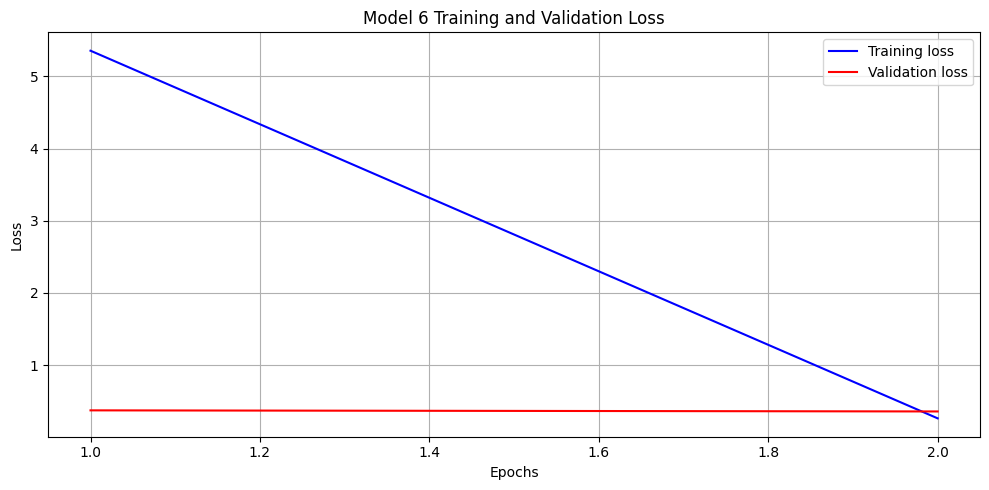

Training completed for model 6


In [290]:
torch.cuda.empty_cache()
gc.collect()
# Train multiple models with different parameters in parallel
train_models("baseline", params)

#### Evaluate BaselineCNN on the Test Data

Accuracy on test image acquisition_alignment/openeo_cities/Berlin/Berlin.tif: 0.8314


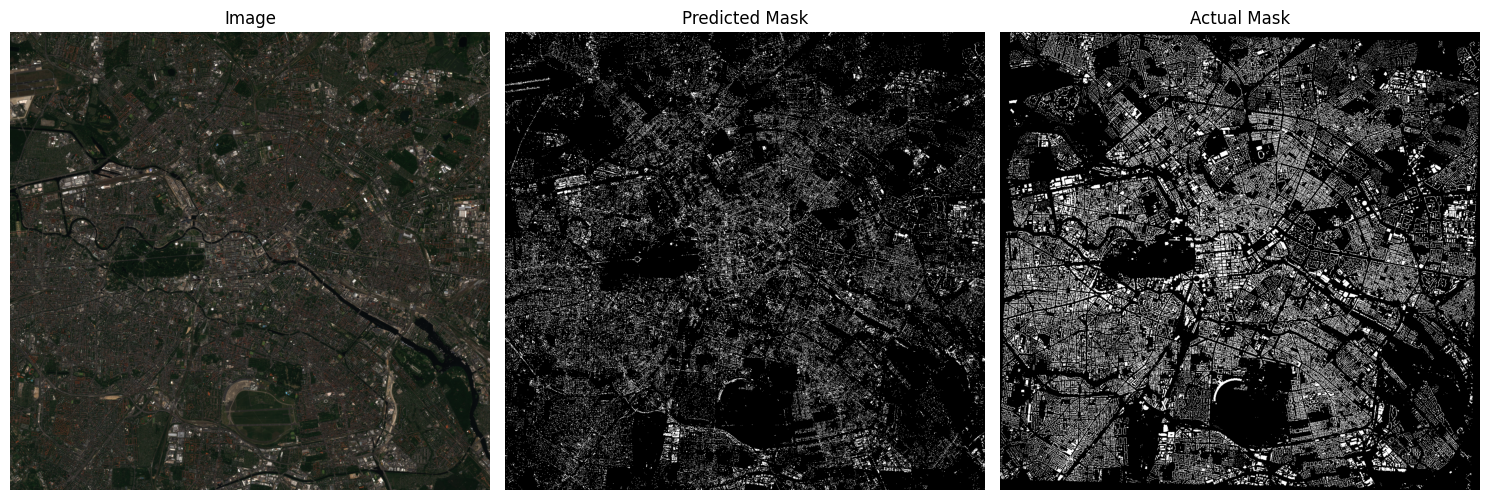

Evaluation complete. Results saved.


In [297]:
# Define paths to test image and mask
image_path = "acquisition_alignment/openeo_cities/Berlin/Berlin.tif"
mask_path = "acquisition_alignment/openeo_cities/Berlin/Berlin_buildings_mask.tif"

# Initialize the model
model = BaselineCNN(in_channels=3)  # (RGB+NIR)

# Load the saved model state dict
model_path = f"modeling_tuning/model_{model_id}/model_{model_id}.pth"
model.load_state_dict(torch.load(model_path))

# Test path for image
img_res_path = f"modeling_tuning/model_{model_id}/"
acc_path = f"modeling_tuning/model_{model_id}/"

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Evaluate the model on test data
accuracy_results = {}

# Forward pass through the model
with torch.no_grad():
    outputs = model(test_image)

# Calculate accuracy
accuracy = calculate_accuracy(outputs.squeeze(), test_mask.to(device))
print(f"Accuracy on test image {image_path}: {accuracy:.4f}")

# Save accuracy result
accuracy_results[image_path] = accuracy

# Convert outputs to binary predictions
predicted_mask = torch.sigmoid(outputs.squeeze()) > 0.5
os.makedirs(img_res_path, exist_ok=True)
# Visualize results and save plots
visualize_results(test_image.squeeze(), predicted_mask, test_mask, save_path=f"{img_res_path}results_{image_path.split('/')[-1]}.png")

os.makedirs(acc_path, exist_ok=True)
# Save accuracy results to a file
with open(f"{acc_path}accuracy_results.txt", "w") as file:
    for image_path, accuracy in accuracy_results.items():
        file.write(f"{image_path}: {accuracy:.4f}\n")

print("Evaluation complete. Results saved.")

### Train UNet Model

Training model 1...


Epoch [1/4],
Training Loss: 0.5597
Validation Loss: 0.3926
Average IoU: 0.0004


Epoch [2/4],
Training Loss: 0.2155
Validation Loss: 0.3596
Average IoU: 0.0005
Early stopping at epoch 2
Best validation loss: 0.3926 at epoch 1


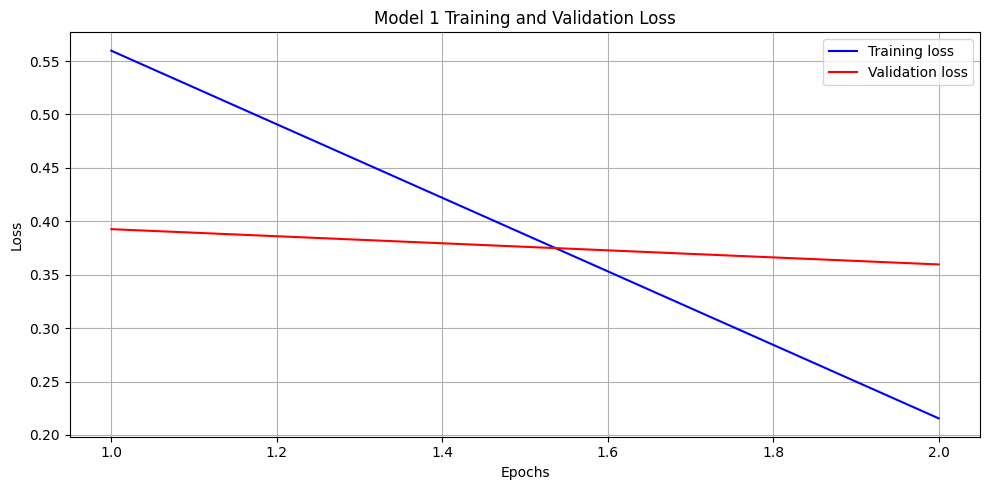

Training completed for model 1


In [191]:
# Train multiple unet models with different parameters in parallel
torch.cuda.empty_cache()
gc.collect()
train_models("unet", params)

#### Evaluate UNet on Test data

Accuracy on test image acquisition_alignment/openeo_cities/Berlin/Berlin.tif: 0.8235


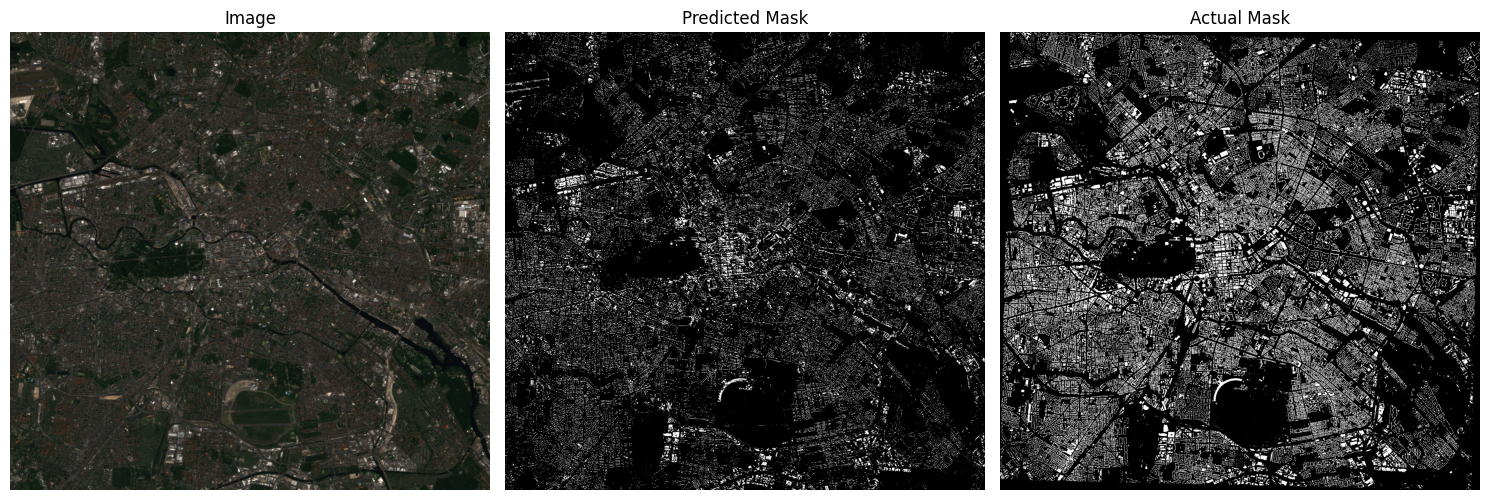

Evaluation complete. Results saved.


In [197]:
# Initialize the model
model = UNet(in_channels=4)  # (RGB+NIR)

# Load the saved model state dict
model_path = f"modeling_tuning/model_{model_id}/model_{model_id}.pth"
model.load_state_dict(torch.load(model_path))

# Test path for image
img_res_path = f"modeling_tuning/model_{model_id}/"
acc_path = f"modeling_tuning/model_{model_id}/"

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Evaluate the model on test data
accuracy_results = {}

# Forward pass through the model
with torch.no_grad():
    # Get current dimensions
    _, height, width = test_image.shape

    # Calculate nearest even dimensions
    target_height = height if height % 2 == 0 else height - 1
    target_width = width if width % 2 == 0 else width - 1

    # Resize images
    test_image = F.interpolate(test_image.unsqueeze(0), size=(target_height, target_width), mode='bilinear', align_corners=True)

    # Resize masks
    test_mask = F.interpolate(test_mask.unsqueeze(0).unsqueeze(0).float(), size=(target_height, target_width), mode='nearest').squeeze(0).squeeze(0) # :|
    outputs = model(test_image)
# Calculate accuracy
accuracy = calculate_accuracy(outputs.squeeze(), test_mask.to(device))
print(f"Accuracy on test image {image_path}: {accuracy:.4f}")

# Save accuracy result
accuracy_results[image_path] = accuracy

# Convert outputs to binary predictions
predicted_mask = torch.sigmoid(outputs.squeeze()) > 0.5
os.makedirs(img_res_path, exist_ok=True)
# Visualize results and save plots
visualize_results(test_image.squeeze(), predicted_mask, test_mask, save_path=f"{img_res_path}results_{image_path.split('/')[-1]}.png")

os.makedirs(acc_path, exist_ok=True)
# Save accuracy results to a file
with open(f"{acc_path}accuracy_results.txt", "w") as file:
    for image_path, accuracy in accuracy_results.items():
        file.write(f"{image_path}: {accuracy:.4f}\n")

print("Evaluation complete. Results saved.")

## 1.4 Data Augmentation

### Define different Transformations

In [279]:
import albumentations as A

# Individual augmentation: Horizontal Flip
train_transformsHF = A.Compose([
    A.HorizontalFlip(p=0.5)
])

# Individual augmentation: Vertical Flip
train_transformsVF = A.Compose([
    A.VerticalFlip(p=0.5)
])

# Individual augmentation: Random Rotate
train_transformsR = A.Compose([
    A.Rotate(limit=180, p=0.5)
])

# Compound augmentations: HF, VF
train_transformsHFVF = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

# Compound augmentations: HF, VF, RO
train_transformsHFVFR = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=180, p=0.5)
])

# Individual augmentation: RGS
train_transformsRGS = A.Compose([
    A.RandomGridShuffle(grid=(2, 2), p=0.5)
])

# Individual augmentation: RGS
train_transformsHFRGS = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomGridShuffle(grid=(2, 2), p=0.5),
])

# Individual augmentation: Mask Dropout
train_transformsMD = A.Compose([
    A.MaskDropout(max_objects=5, image_fill_value=0, mask_fill_value=0, p=0.5),
])

# Compound augmentation: 
train_transformsMDRGS = A.Compose([
    A.MaskDropout(max_objects=5, image_fill_value=0, mask_fill_value=0, p=0.5),
    A.RandomGridShuffle(grid=(3, 3), p=0.5),
])

# Individual augmentation: Crop
train_transformsRC = A.Compose([
    A.RandomCrop(height=64, width=64, p=1),
])

# Individual augmentation: RGS
train_transformsCRGS = A.Compose([
    A.RandomCrop(height=64, width=64, p=1),
    A.RandomGridShuffle(grid=(2, 2), p=0.5)
])

### Define Custom Dataset Class

In [280]:
class CustomTensorDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        if self.transform:
            # Convert torch tensors to numpy arrays
            image_np = image.permute(1, 2, 0).cpu().numpy()
            mask_np = mask.cpu().numpy()

            # Apply the Albumentations transformation
            augmented = self.transform(image=image_np, mask=mask_np)
            image_np, mask_np = augmented['image'], augmented['mask']

            # Convert numpy arrays back to torch tensors
            image = torch.tensor(image_np).permute(2, 0, 1)
            mask = torch.tensor(mask_np)
            
        return image, mask

### Create DataLoader

In [282]:
# Create TensorDataset and DataLoader for training and validation
train_dataset = CustomTensorDataset(train_images, train_masks, transform=train_transformsRGS)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(val_images, val_masks)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Use batch_size=1 for validation

### Train with Data Augmentation

Training model 4...


Epoch [1/4],
Training Loss: 3.4143
Validation Loss: 0.3226
Average IoU: 0.2427


Epoch [2/4],
Training Loss: 0.2238
Validation Loss: 0.3152
Average IoU: 0.2820
Early stopping at epoch 2
Best validation loss: 0.3226 at epoch 1


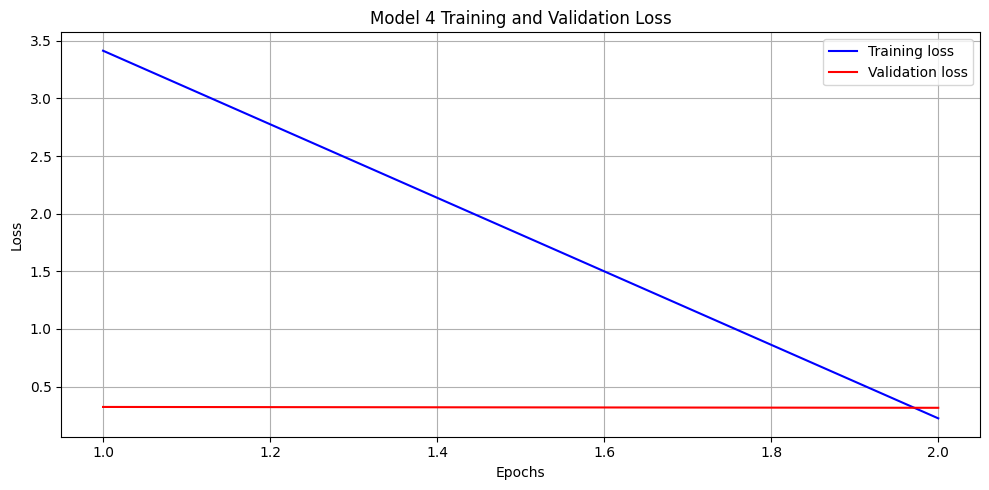

Training completed for model 4


In [283]:
torch.cuda.empty_cache()
gc.collect()
# Train multiple models with different parameters in parallel if any
train_models("baseline", params)

#### Evaluate on Test data with Augmentation

Accuracy on test image acquisition_alignment/openeo_cities/Berlin/Berlin.tif: 0.8415


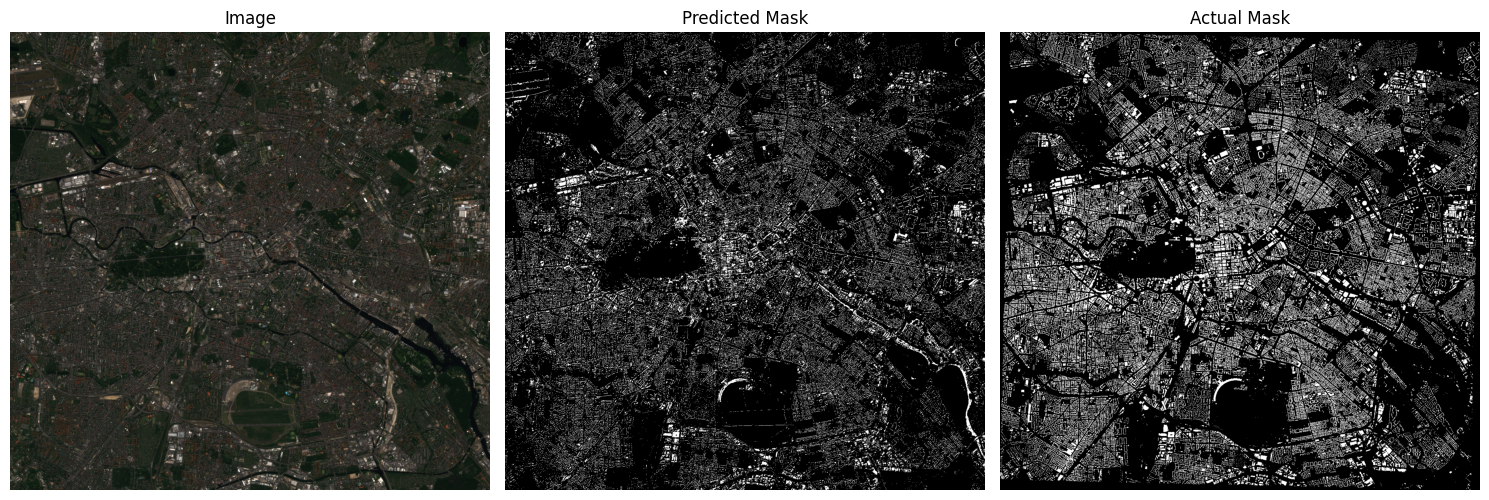

Evaluation complete. Results saved.


In [284]:
# Initialize the model
model = BaselineCNN(in_channels=4)  # (RGB+NIR)

# Load the saved model state dict
model_path = f"modeling_tuning/model_{model_id}/model_{model_id}.pth"

# Test path for image
img_res_path = f"modeling_tuning/model_{model_id}/"
acc_path = f"modeling_tuning/model_{model_id}/"

model.load_state_dict(torch.load(model_path))

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Evaluate the model on test data
accuracy_results = {}

# Forward pass through the model
with torch.no_grad():
    outputs = model(test_image)

# Calculate accuracy
accuracy = calculate_accuracy(outputs.squeeze(), test_mask.to(device))
print(f"Accuracy on test image {image_path}: {accuracy:.4f}")

# Save accuracy result
accuracy_results[image_path] = accuracy

# Convert outputs to binary predictions
predicted_mask = torch.sigmoid(outputs.squeeze()) > 0.5
os.makedirs(img_res_path, exist_ok=True)
# Visualize results and save plots
visualize_results(test_image.squeeze(), predicted_mask, test_mask, save_path=f"{img_res_path}results_{image_path.split('/')[-1]}.png")

os.makedirs(acc_path, exist_ok=True)
# Save accuracy results to a file
with open(f"{acc_path}accuracy_results.txt", "w") as file:
    for image_path, accuracy in accuracy_results.items():
        file.write(f"{image_path}: {accuracy:.4f}\n")

print("Evaluation complete. Results saved.")